In [86]:
#Here info:
#App ID: gB5Th31Aa7kCMDRB2yYH
#App Code: _V3OMdtHzj0vDll0eT6JsA

from sklearn.ensemble import RandomForestClassifier
from sklearn import (metrics, model_selection, linear_model, preprocessing, ensemble, neighbors, tree)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import numpy as np
import pandas as pd
import pprint as pp
import re
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from IPython.display import Image 



Tree train accuracy:  0.617391304348
Tree test accuracy:  0.575305291723


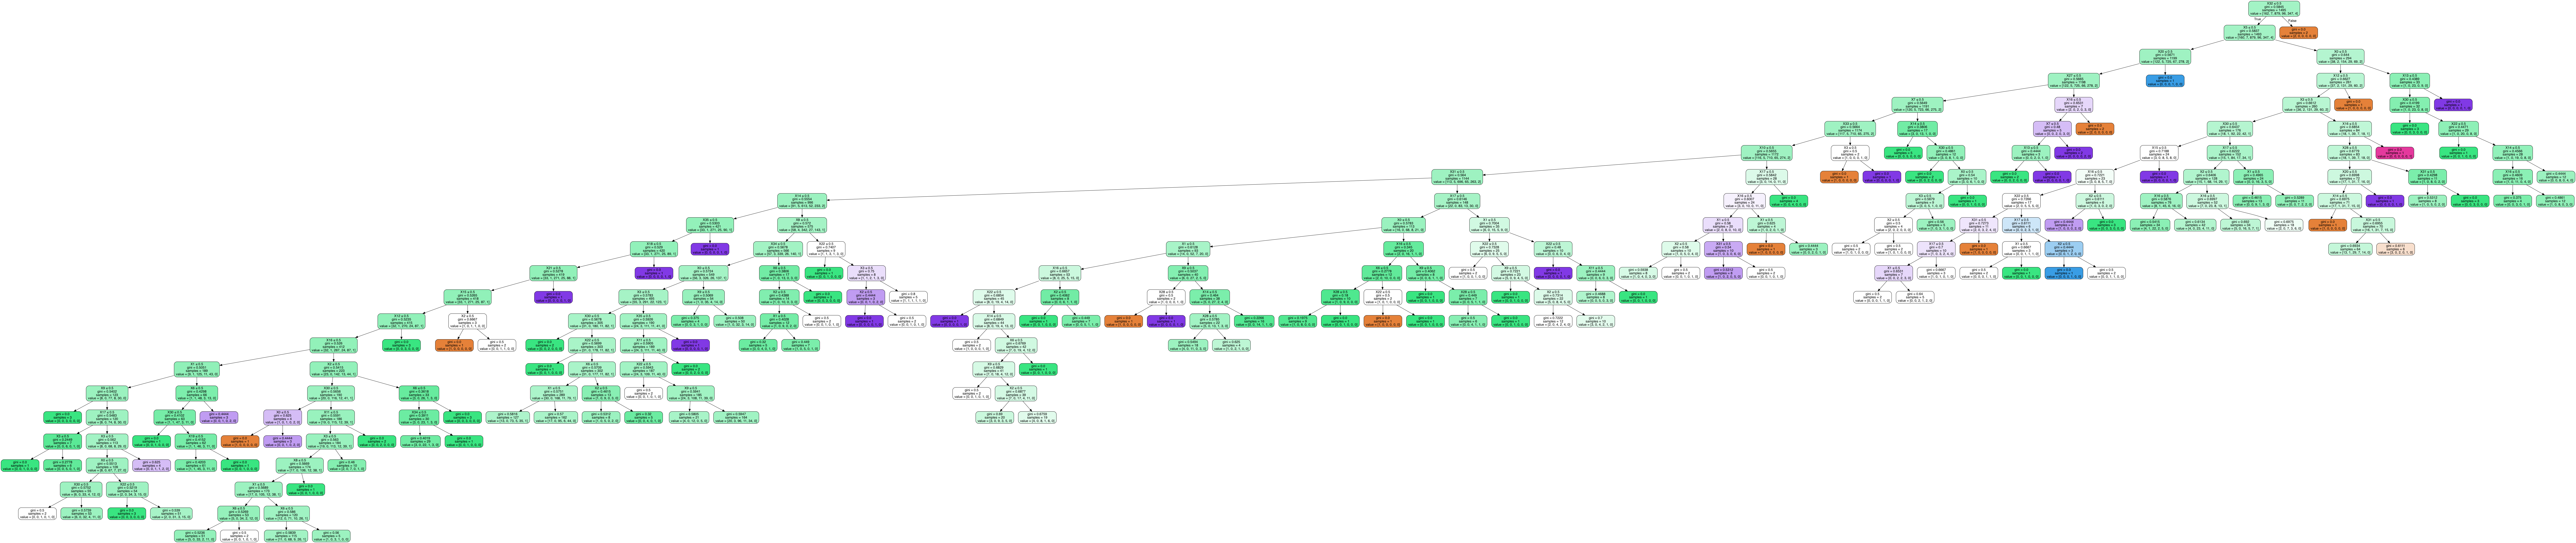

In [113]:
# Use DecisionTreeClassifier with a limited number of features and visualize
# the the resulting tree

# https://research.vahula.com/scikit-learns-decision-tree-classifier-698ddbb05b
# http://scikit-learn.org/stable/modules/tree.html

# import the "crash" data
data = pd.read_csv("my_map_grid.csv",header=10)

# preprocessing
# lowercase: http://stackoverflow.com/a/38931854
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')
# special cases
data.columns = data.columns.str.replace('crash_i_d', 'crash_id')
# remove whateva data

# replace ['No Data','Not Applicable'] with NaN
data.replace(to_replace='No Data', value=np.nan, inplace=True)
data.replace(to_replace='Not Applicable', value=np.nan, inplace=True)
data.latitude = pd.to_numeric(data.latitude)
data.longitude = pd.to_numeric(data.longitude)

# Let's select a small number of important features
# smalldf = data[['crash_severity',
#                 'crash_time', 
#                 'day_of_week', 
#                 'intersection_related', 
#                 'light_condition', 
#                 'manner_of_collision',
#                 'speed_limit',
#                 'surface_condition', 
#                 'weather_condition']]

# smalldf.head()

# dummies_needed_list = [
#  'day_of_week',
#  'intersection_related',
#  'light_condition',
#  'manner_of_collision',
#  'surface_condition',
#  'weather_condition']

smalldf = data[['crash_severity', 
                'intersection_related', 
                'light_condition', 
                'manner_of_collision',
                'surface_condition', 
                'weather_condition']]

smalldf.head()

dummies_needed_list = [
 'intersection_related',
 'light_condition',
 'manner_of_collision',
 'surface_condition',
 'weather_condition']

# encode data for dummies_needed_list
for feat in dummies_needed_list:
    smalldf = pd.concat([smalldf,pd.get_dummies(smalldf[feat],prefix=feat)],axis=1)
    smalldf = smalldf.drop([feat],axis=1)
    
smalldf.head()
X = smalldf.drop(['crash_severity'], axis=1)
y = smalldf['crash_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(X_train, y_train)

train_accuracy = tree_classifier.score(X_train, y_train)
test_accuracy = tree_classifier.score(X_test, y_test)
print('Tree train accuracy: ', train_accuracy)
print('Tree test accuracy: ', test_accuracy)

# graphviz needs to be installed
# on mac: brew install graphviz
# http://stackoverflow.com/questions/18438997/why-is-pydot-unable-to-find-graphvizs-executables-in-windows-8

# The feature_names and class_names oprtional parameters should be set so that the tree
# can have the actual names of features and classes
# http://scikit-learn.org/stable/modules/tree.html#classification
dot_data = tree.export_graphviz(tree_classifier, out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#print(tree_classifier.feature_importances_)


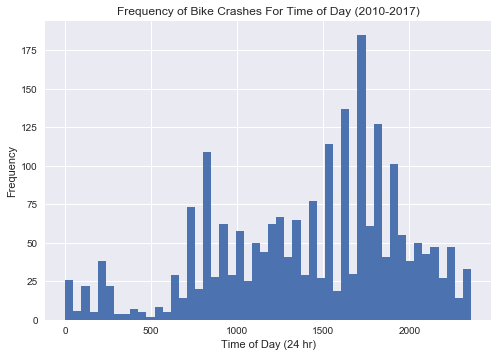

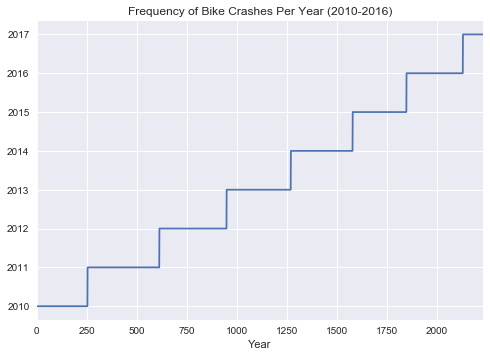

In [137]:
# Let's see the realationship between crashes and time of day
# First, let's just look at the total crashes vs time of day (no crash severity)

data = pd.read_csv("my_map_grid.csv",header=10)
data['Crash Time'].plot.hist(bins=50)
plt.xlabel('Time of Day (24 hr)')
plt.title('Frequency of Bike Crashes For Time of Day (2010-2017)')
plt.show()

# Let's see if there is a trend of total bike crashes by year
data['Crash Year'].plot.hist()
plt.xlabel('Year')
plt.title('Frequency of Bike Crashes Per Year (2010-2016)')
plt.show()



In [18]:
# import the "crash" data
data = pd.read_csv("my_map_grid.csv",header=10)

# preprocessing
# lowercase: http://stackoverflow.com/a/38931854
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')
# special cases
data.columns = data.columns.str.replace('crash_i_d', 'crash_id')
# remove whateva data

# replace ['No Data','Not Applicable'] with NaN
data.replace(to_replace='No Data', value=np.nan, inplace=True)
data.replace(to_replace='Not Applicable', value=np.nan, inplace=True)
data.latitude = pd.to_numeric(data.latitude)
data.longitude = pd.to_numeric(data.longitude)


dummies_needed_list = [
 'day_of_week',
 'intersection_related',
 'light_condition',
 'manner_of_collision',
 'road_base_type',
 'surface_condition',
 'weather_condition'
        ]
# encode data for dummies_needed_list
for feat in dummies_needed_list:
    data = pd.concat([data,pd.get_dummies(data[feat],prefix=feat)],axis=1)
    data = data.drop([feat],axis=1)

#remove data that will not be usefull
drop_columns = ['crash_id',
                'average_daily_traffic_amount',
                'average_daily_traffic_year',
                'street_name',
                'intersecting_street_name',
                'medical_advisory_flag',
                'object_struck']
crash_id = data.crash_id
data = data.drop(drop_columns,axis=1)

#fill missing values
data = data.fillna(data.mean())

#split data into train/test,x/y
np.random.seed(0)
train, test = train_test_split(data)
x_train = train.drop(['crash_severity'],axis=1)
y_train = train.crash_severity
x_test = test.drop(['crash_severity'],axis=1)
y_test = test.crash_severity

In [24]:
#test models from data will need a model that can classify more than 2 response classes

#cross validation function
def accuracy_cv(model):
    accuracy = cross_val_score(model,x_train,y_train.as_matrix().ravel(),scoring='accuracy',cv=5)
    return (accuracy)

n_neighbors = np.linspace(14,23,10,dtype=int)

knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

#cross validation for n_neighbors parameter
scores = [accuracy_cv(KNeighborsClassifier(n_neighbors=n_neighbor)).mean()
          for n_neighbor in n_neighbors]

C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\weyma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The mi

0.52867383512544808

In [31]:
#cross validation function
def accuracy_cv(model):
    accuracy = cross_val_score(model,x_train,y_train.as_matrix().ravel(),scoring='accuracy',cv=5)
    return (accuracy)

model_xgb = xgb.XGBClassifier()
model_xgb.fit(x_train,y_train)
print("XGB Train accuracy:", model_xgb.score(x_train,y_train))
print("XGB Test accuracy:",model_xgb.score(x_test,y_test))


XGB Train accuracy: 1.0
XGB Test accuracy: 0.992831541219


In [2]:
import urllib.request
urllib.request.urlopen('https://legacy.route.cit.api.here.com/routing/6.2/getlinkinfo.json?waypoint=37.3936%2C%20-122.07909&app_id=DemoAppId01082013GAL&app_code=AJKnXv84fjrb0KIHawS0Tg').read()

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [43]:
import geocoder

g = geocoder.here([29.42458,-98.49461],app_id='gB5Th31Aa7kCMDRB2yYH',app_code='_V3OMdtHzj0vDll0eT6JsA',method='reverse',mode='retrieveAll',responseattributes='SpeedLimitType')
g.url

'http://reverse.geocoder.cit.api.here.com/6.2/reversegeocode.json?prox=29.42458%2C+-98.49461&app_id=gB5Th31Aa7kCMDRB2yYH&app_code=_V3OMdtHzj0vDll0eT6JsA&mode=retrieveAddresses&gen=8&language='

In [ ]:
# convert 'Wet' 'Dry' to '1' '0'
data['surface_condition'] = data['surface_condition'].factorize()[0]
# DOC: rename col http://stackoverflow.com/a/11346337
data.rename(columns={'surface_condition':'surface_wet'})
# print number of unique
for colname in data.columns:
    print("% 4d : %s" % (len(data[colname].unique()), colname))
# remove data which is has no importance
# better to drop cols with all NaN and convert "unimportant" data to NaN
#  - can't universally decide to drop col just based on uniqueness
# e.g. all of object_struck is 'Not Applicable' and useless, but if surface_condition had only one value "dry" this would be important
# ? for colname in data.columns:
# colname = 'object_struck'
# if(len(data[colname].unique()) == 1):
#   print("-I-: dropping %s for having all homogenous values %s", (colname, data[colname].unique()[0]))
#   data.drop(colname,axis=1,inplace=True)


    

print(data.head())
print(data.info())
if(1):
  data.describe()
  data.hist()
  data.corr().plot() # TODO: seaborn
  plt.show()
else:
  print("-I-: Skipping...")

pairplot_var_list = [
# 'crash_id',
 'average_daily_traffic_amount',
 'average_daily_traffic_year',
 'crash_death_count',
# 'crash_incapacitating_injury_count',
# 'crash_non-incapacitating_injury_count',
# 'crash_not_injured_count',
# 'crash_possible_injury_count',
 'crash_severity',
 'crash_time',
 'crash_year',
 'day_of_week',
# 'intersecting_street_name',
 'intersection_related',
# 'latitude',
 'light_condition',
# 'longitude',
 'manner_of_collision',
 'medical_advisory_flag',
 'number_of_entering_roads',
 'number_of_lanes',
# 'object_struck',
 'road_base_type',
 'speed_limit',
# 'street_name',
 'surface_condition'
 ]

# tmp disable
if(0):
    sns.pairplot(data, vars=pairplot_var_list)
    plt.show()

# alternative visualisation
datapt = data.pivot_table(values=['crash_death_count','crash_incapacitating_injury_count','crash_non-incapacitating_injury_count'], index=['speed_limit','crash_time'])
print(datapt)

pp.pprint(list(pd.get_dummies(data[dummies_needed_list]).columns))
pp.pprint(list(pd.get_dummies(data[dummies_needed_list]).columns.str.replace('[,\s]+','_').str.lower()))
'''
 'Dark, Lighted', 'dark_lighted_yes'
 'Dark, Not Lighted', 'dark_lighted_no'
 'Dark, Unknown Lighting', 'dark_lighted_unknown'
 'Dawn',
 'Daylight',
 'Dusk',
 'Unknown',
'''